In [ ]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('/root/project')) # add root path to sys.path
sys.path.append(os.path.abspath('/usr/local/lib/python3.10/dist-packages'))
from util import util_constants
from util import util_funcs
import database_init as database_init
import f4_evaluate.evaluate_scene as evaluate_scene

# dataset comparison
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

#pairwise similarity
import pickle

FileNotFoundError: [Errno 2] No such file or directory: 'data_annotation/goalstep/'

In [16]:
# PATHS
PATH_CURR_FOLDER = os.path.abspath('') 
PATH_DATA_ANNOTATION = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_annotation'))
PATH_DATA_INPUT_OUTPUT = os.path.abspath(os.path.join(PATH_CURR_FOLDER, '..', 'data_input_output'))
TEST_SPATIAL_ANNOTATION_PATH_MANUAL = PATH_DATA_ANNOTATION + '/spatial_testset/manual'

TEST_SPATIAL_ANNOTATION_PATH_SEMI = PATH_DATA_ANNOTATION + '/spatial_testset/semi'    
TEST_SPATIAL_ANNOTATION_PATH_AUG100 = PATH_DATA_ANNOTATION + '/spatial_augmentation/TESTSET_Augmented_Data_100_v3' 
TEST_SPATIAL_ANNOTATION_PATH_AUG67 = PATH_DATA_ANNOTATION + '/spatial_augmentation/TESTSET_Augmented_Data_67_v3' 
TEST_SPATIAL_ANNOTATION_PATH_AUG33 = PATH_DATA_ANNOTATION + '/spatial_augmentation/TESTSET_Augmented_Data_33_v3' 

# PATH for PAIRSIM_RESULTS
TEST_PAIRSIM_RESULT_PATH = PATH_DATA_ANNOTATION + '/spatial_pairsim_result/'  


In [19]:
# PREPROCESS VIDEO_LISTS for TEST DATA
test_spatial_video_list = database_init.make_spatial_json_video_list(TEST_SPATIAL_ANNOTATION_PATH_MANUAL, TEST_SPATIAL_ANNOTATION_PATH_SEMI)
test_spatial_video_aug100_list = database_init.make_spatial_json_video_list_singlepath(TEST_SPATIAL_ANNOTATION_PATH_AUG100)
test_spatial_video_aug67_list = database_init.make_spatial_json_video_list_singlepath(TEST_SPATIAL_ANNOTATION_PATH_AUG67)
test_spatial_video_aug33_list = database_init.make_spatial_json_video_list_singlepath(TEST_SPATIAL_ANNOTATION_PATH_AUG33)

print(len(test_spatial_video_list))
print(len(test_spatial_video_aug100_list))
print(len(test_spatial_video_aug67_list))
print(len(test_spatial_video_aug33_list))


# REPAIR GRAPH
def repair_graph(dict_list):
    """
    func: in dict_list, repair faulty graph that only give string rather than dictionalry in the "init_status"
    input: dict_list
    output: dict_list with repaired graphs
    """
    for i in range(len(dict_list)):
        graph = dict_list[i]['spatial_data']
        id = dict_list[i]['video_id']
        for obj in graph:
            init_status = obj.get("init_status")
            
            if isinstance(init_status, str):
                obj["init_status"] = {
                    "status": init_status,
                    "container": None
                }
    return dict_list


sorted_test_video_list = sorted(test_spatial_video_list, key=lambda x: x["video_id"])
sorted_test_video_list= repair_graph(sorted_test_video_list)
sorted_test_video_aug33_list = sorted(test_spatial_video_aug33_list, key=lambda x: x["video_id"])
sorted_test_video_aug67_list = sorted(test_spatial_video_aug67_list, key=lambda x: x["video_id"])
sorted_test_video_aug100_list = sorted(test_spatial_video_aug100_list, key=lambda x: x["video_id"])

for i in range(len(sorted_test_video_list)):
    print(sorted_test_video_list[i]['video_id'])

71
71
71
71
01ce4fd6-197a-4792-8778-775b03780369
026dac2d-2ab3-4f9c-9e1d-6198db4fb080
02a06bf1-51b8-4902-b088-573e29fcd7ec
14bcb17c-f70a-41d5-b10d-294388084dfc
1a894d3c-b3ef-448a-a3de-2b38677cef36
1dc85adb-fbdd-4275-b9cf-42976acb4d14
24ba7993-7fc8-4447-afd5-7ff6d548b11a
28e0affc-cacb-4db8-ab32-dfc16931b86a
2978ddbc-cdc9-4bfa-9a7c-4bf056904010
29e00040-6e0f-4f0e-816d-1ac97c1e5485
2ba0becb-58c2-43a1-97bb-7e153a34eb47
2bc7d6fa-a02e-4367-b316-d6b4e8a2ce3f
2c27b5f1-4af6-49ad-a43c-3efb0c150868
2da5c1ee-bd40-406d-83a7-2f3d93293949
2f46d1e6-2a85-4d46-b955-10c2eded661c
31d6fe77-da70-42da-8f47-66bb79b9285b
321b5e21-2951-40c9-a2f9-6ce0c145cfb8
341b5211-bb72-4bec-bd3d-c0d518887960
35080724-6604-401c-8b06-19b7cece3d45
3728f856-0d47-4614-824f-37b6dda8e357
38a7b760-56f9-4565-8b70-f8dad5768ace
3ec3eab7-842d-409d-8866-42ddcbd24cd9
46e07357-6946-4ff0-ba36-ae11840bdc39
47bb1fd4-d41f-42b4-8d0c-29c4e9fdff9f
487d752c-6e22-43e3-9c08-627bc2a6c6d4
4fa75795-ddc4-4582-9715-bb7887439263
543e4c99-5d9f-407d-be75-c3

# Pairwise Similarity (SBERT f1 score for ENTITY/RELATIONSHIP)

In [4]:
# #--------------------------------
# #TESTING for first file
# #--------------------------------
#Sort test_spatial_video_list first
# sorted_test_video_list = sorted(test_spatial_video_list, key=lambda x: x["video_id"])
# dict_list = sorted_test_video_list

# sorted_test_video_aug33_list = sorted(test_spatial_video_aug33_list, key=lambda x: x["video_id"])
# dict_list_aug33 = sorted_test_video_aug33_list

# sorted_test_video_aug67_list = sorted(test_spatial_video_aug67_list, key=lambda x: x["video_id"])
# dict_list_aug67 = sorted_test_video_aug67_list

# sorted_test_video_aug100_list = sorted(test_spatial_video_aug100_list, key=lambda x: x["video_id"])
# dict_list_aug100 = sorted_test_video_aug100_list

# # TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
# data_0 = dict_list[0]['spatial_data']
# for i in range(len(dict_list)):  
#     data_i = dict_list[i]['spatial_data']  
#     print(f"{i}: {dict_list[i]['video_id']}")
#     evaluate_scene.compare_scene_graphs_dict(data_0, data_i)  

# # TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
# print("\n AUG33: \n")
# data_0_aug33 = dict_list_aug33[0]['spatial_data']
# for i in range(1, len(dict_list_aug33)):  
#     data_i = dict_list_aug33[i]['spatial_data']  
#     print(f"{i}: {dict_list_aug33[i]['video_id']}")
#     evaluate_scene.compare_scene_graphs_dict(data_0_aug33, data_i)  

# # TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
# print("\n AUG67: \n")
# data_0_aug67 = dict_list_aug67[0]['spatial_data']
# for i in range(1, len(dict_list_aug67)):  
#     data_i = dict_list_aug67[i]['spatial_data']  
#     print(f"{i}: {dict_list_aug67[i]['video_id']}")
#     evaluate_scene.compare_scene_graphs_dict(data_0_aug67, data_i)  

# # TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
# print("\n AUG100: \n")
# data_0_aug100 = dict_list_aug100[0]['spatial_data']
# for i in range(1, len(dict_list_aug100)):  
#     data_i = dict_list_aug100[i]['spatial_data']  
#     print(f"{i}: {dict_list_aug100[i]['video_id']}")
#     evaluate_scene.compare_scene_graphs_dict(data_0_aug100, data_i)   


#--------------------------------
#ALL PAIRWISE COMPARISON
#--------------------------------
import pickle
util_funcs.remove_files(TEST_PAIRSIM_RESULT_PATH)

#Sort test_spatial_video_list first
sorted_test_video_list = sorted(test_spatial_video_list, key=lambda x: x["video_id"])
sorted_test_video_aug33_list = sorted(test_spatial_video_aug33_list, key=lambda x: x["video_id"])
sorted_test_video_aug67_list = sorted(test_spatial_video_aug67_list, key=lambda x: x["video_id"])
sorted_test_video_aug100_list = sorted(test_spatial_video_aug100_list, key=lambda x: x["video_id"])

dict_list = sorted_test_video_list
dict_list_aug33 = sorted_test_video_aug33_list
dict_list_aug67 = sorted_test_video_aug67_list
dict_list_aug100 = sorted_test_video_aug100_list

# TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
for j in range(len(dict_list)):
    data_j = dict_list[j]['spatial_data']
    result_list = []
    name = TEST_PAIRSIM_RESULT_PATH+f"comparision_augno_{j}.pkl"
    
    for i in range(len(dict_list)):  
        data_i = dict_list[i]['spatial_data']    
        # print(f"{i}: {dict_list[i]['video_id']}")      
        result = evaluate_scene.compare_scene_graphs_dict_return(data_j, data_i)
        result_list.append(result)

    with open(name, 'wb') as f:
        pickle.dump(result_list, f)        
        print(f"comparision_augno_{j}")   


# TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
print("\n AUG33: \n")
for j in range(len(dict_list_aug33)):
    data_j = dict_list_aug33[j]['spatial_data']
    result_list = []
    name = TEST_PAIRSIM_RESULT_PATH+f"comparision_aug33_{j}.pkl"

    for i in range(len(dict_list_aug33)):  
        data_i = dict_list_aug33[i]['spatial_data']  
        print(f"{i}: {dict_list_aug33[i]['video_id']}")
        result = evaluate_scene.compare_scene_graphs_dict_return(data_j, data_i)
        result_list.append(result)

    with open(name, 'wb') as f:
        pickle.dump(result_list, f)     
        print(f"comparision_aug33_{j}")      

# TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
print("\n AUG67: \n")
for j in range(len(dict_list_aug67)):
    data_j = dict_list_aug67[j]['spatial_data']
    result_list = []
    name = TEST_PAIRSIM_RESULT_PATH+f"comparision_aug67_{j}.pkl"

    for i in range(len(dict_list_aug67)):  
        data_i = dict_list_aug67[i]['spatial_data']  
        # print(f"{i}: {dict_list_aug67[i]['video_id']}")
        result = evaluate_scene.compare_scene_graphs_dict_return(data_j, data_i)
        result_list.append(result)

    with open(name, 'wb') as f:
        pickle.dump(result_list, f)    
        print(f"comparision_aug67_{j}")          

# TEST COMPARISON FOR SCENE(0) VS SCENE(N+1)
print("\n AUG100: \n")
for j in range(len(dict_list_aug100)):
    data_j = dict_list_aug100[j]['spatial_data']
    result_list = []
    name = TEST_PAIRSIM_RESULT_PATH+f"comparision_aug100_{j}.pkl"

    for i in range(len(dict_list_aug100)):  
        data_i = dict_list_aug100[i]['spatial_data']  
        # print(f"{i}: {dict_list_aug100[i]['video_id']}")
        result = evaluate_scene.compare_scene_graphs_dict_return(data_j, data_i)
        result_list.append(result)

    with open(name, 'wb') as f:
        pickle.dump(result_list, f)
        print(f"comparision_aug100_{j}")  

Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_aug100_62.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_augno_16.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_aug67_44.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_aug33_22.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_augno_35.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_augno_46.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_aug67_51.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_augno_50.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_augno_15.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_aug100_6.pkl
Removed: /root/project/data_annotation/spatial_pairsim_result/comparision_augno_48.pkl
Removed: /root/project/data_annotation/spa

## DATASET COMPARISON
- tsne for all graphs
- tsne for all augmentation formats
- similarity metric for different augmentation format


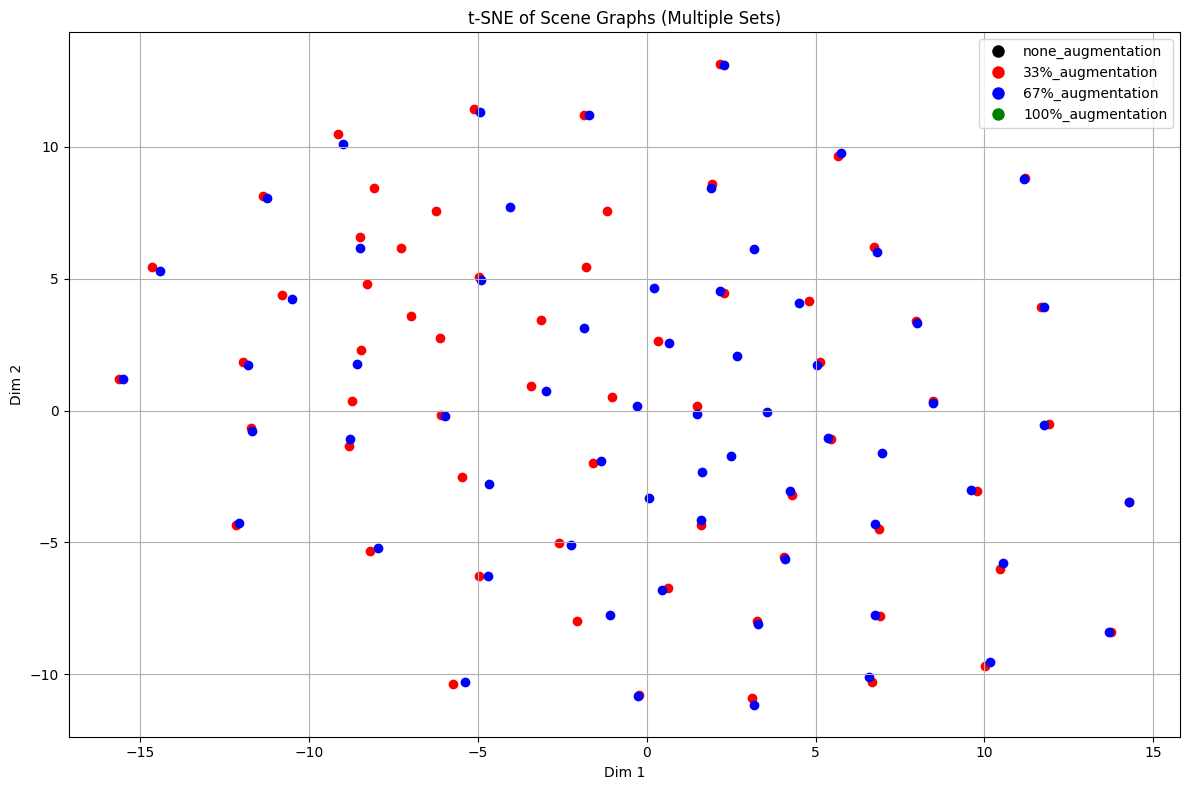

In [35]:
# Load SBERT
model = SentenceTransformer("all-MiniLM-L6-v2")
def delete_faulty_scene(dict_list):
    """
    func: in dict_list, delete faulty graph
    input: dict_list
    output: dict_list without faulty list
    """
    final_dict_list =[]
    for i in range(len(dict_list)):
        graph = dict_list[i]['spatial_data']
        id = dict_list[i]['video_id']
        try:
            object_names = [obj["object_name"] for obj in graph]
            relationships = []

            for obj in graph:
                container_id = obj.get("init_status", {}).get("container")
                if container_id is not None:
                    parent = next((o for o in graph if o["object_id"] == container_id), None)
                    if parent:
                        relationships.append(f"{obj['object_name']} in {parent['object_name']}")
            
            final_dict_list.append(dict_list[i])
        except json.JSONDecodeError as e:
            print(f"Error reading spatial {id}: {e}")
    
    print(len(final_dict_list))
    return final_dict_list

def repair_graph(dict_list):
    """
    func: in dict_list, repair faulty graph that only give string rather than dictionalry in the "init_status"
    input: dict_list
    output: dict_list with repaired graphs
    """
    for i in range(len(dict_list)):
        graph = dict_list[i]['spatial_data']
        id = dict_list[i]['video_id']
        for obj in graph:
            init_status = obj.get("init_status")
            
            if isinstance(init_status, str):
                obj["init_status"] = {
                    "status": init_status,
                    "container": None
                }
    return dict_list

def embed_scene_graph(graph):
    """
    func: embed spatial_data with sbert\n
    input: graph(=dictionary[i]['spatial_data'])\n
    return: encoded text
    """
    object_names = [obj["object_name"] for obj in graph]
    relationships = []

    for obj in graph:
        container_id = obj.get("init_status", {}).get("container")
        if container_id is not None:
            parent = next((o for o in graph if o["object_id"] == container_id), None)
            if parent:
                relationships.append(f"{obj['object_name']} in {parent['object_name']}")

    # Combine object names and container relations as a pseudo "document"
    full_text = "; ".join(object_names + relationships)
    return model.encode(full_text)

def plot_tsne_scene_graphs(dict_list):
    """

    """
    # files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith(".json")]
    # embeddings = []
    # labels = []
    # for file_path in files:
    #     emb = embed_scene_graph(file_path)
    #     embeddings.append(emb)
    #     labels.append(os.path.basename(file_path))  # Use filename as label

    embeddings = []
    labels = []
    for i in range(len(dict_list)):
        print(f"{i}th video in dict_list")
        video_id = dict_list[i]['video_id']
        spatial_data_graph = dict_list[i]['spatial_data']
        emb = embed_scene_graph(spatial_data_graph)
        embeddings.append(emb)
        labels.append(video_id)  # Use video_id as label

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))    

    # Plotting
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        x, y = embeddings_2d[i]
        plt.scatter(x, y, marker='o')
        plt.text(x + 0.5, y + 0.5, label, fontsize=8)
    plt.title("t-SNE of Scene Graphs")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Multiplot
def plot_tsne_multiple_scene_graphs(lists_with_labels):
    """
    lists_with_labels: List of (dict_list, label_name) tuples
    """
    all_embeddings = []
    all_labels = []
    all_colors = []

    color_map = {
        "none": "black",
        "33%": "red",
        "67%": "blue",
        "100%": "green"
    }

    for dict_list, label_name in lists_with_labels:
        for i in range(len(dict_list)):
            video_id = dict_list[i]['video_id']
            spatial_data_graph = dict_list[i]['spatial_data']
            emb = embed_scene_graph(spatial_data_graph)
            all_embeddings.append(emb)
            all_labels.append(video_id)
            all_colors.append(color_map[label_name])

    tsne = TSNE(n_components=2, perplexity=min(30, len(all_embeddings) - 1), random_state=42)
    embeddings_2d = tsne.fit_transform(np.array(all_embeddings))

    # Plot
    plt.figure(figsize=(12, 8))
    for i, (x, y) in enumerate(embeddings_2d):
        plt.scatter(x, y, color=all_colors[i], label=all_colors[i] if all_labels[i] not in all_labels[:i] else "")
        #plt.text(x + 0.5, y + 0.5, all_labels[i], fontsize=8)

    # Legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label+"_augmentation", markerfacecolor=color_map[label], markersize=10)
               for label in color_map]
    plt.legend(handles=handles)

    plt.title("t-SNE of Scene Graphs (Multiple Sets)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# new_sorted_test_video_list = delete_faulty_scene(sorted_test_video_list)

new_sorted_test_video_list= repair_graph(sorted_test_video_list)
# plot_tsne_scene_graphs(new_sorted_test_video_list)
# plot_tsne_scene_graphs(sorted_test_video_aug33_list)
# plot_tsne_scene_graphs(sorted_test_video_aug67_list)
# plot_tsne_scene_graphs(sorted_test_video_aug100_list)

plot_tsne_multiple_scene_graphs([
    #(new_sorted_test_video_list, "none"),
    (sorted_test_video_aug33_list, "33%"),
    (sorted_test_video_aug67_list, "67%"),
    # (sorted_test_video_aug100_list, "100%")
])


In [35]:
# Similarity Plot functions

# for each dataset (none, aug33, aug67, aug100)
#element = {"precision": precision, "recall": recall, "f1_score": f1, "matches": matches}
# comparison_augXX_NO = [e0, ..., e70] for augXX


def summarize(index ,values, name):  
    print(f"file {i}: {name} /  Mean: {np.mean(values):.4f} Std: {np.std(values):.4f} Median: {np.median(values):.4f}")
# Load the pickle file

#=============================
# F1 Score for each file(70)
#=============================
file_list_all=[]
for i in range(71):
    file_path = TEST_PAIRSIM_RESULT_PATH + "comparision_augno_" + str(i) +".pkl"
    file_path1 = TEST_PAIRSIM_RESULT_PATH + "comparision_aug33_" + str(i) +".pkl"
    file_path2 = TEST_PAIRSIM_RESULT_PATH + "comparision_aug67_" + str(i) +".pkl"
    file_path3 = TEST_PAIRSIM_RESULT_PATH + "comparision_aug100_" + str(i) +".pkl"

    file_list0 = []
    file_list1 = []
    file_list2 = []
    file_list3 = []
    # print(f"{i}th datum comparison of none, 33, 67, 100")
    with open(file_path, "rb") as f:
        data = pickle.load(f)    
        data = data[:i] + data[i+1:]
        file_list0.extend(data)
        # file_list_all.extend(data)
    with open(file_path1, "rb") as f:
        data = pickle.load(f)
        data = data[:i] + data[i+1:]
        file_list1.extend(data)
        # file_list_all.extend(data)
    with open(file_path2, "rb") as f:
        data = pickle.load(f)
        data = data[:i] + data[i+1:]
        file_list2.extend(data)
        # file_list_all.extend(data)
    with open(file_path3, "rb") as f:
        data = pickle.load(f) 
        data = data[:i] + data[i+1:]
        file_list3.extend(data)               
        # file_list_all.extend(data)

    # only consider entity results from file_list
    # entity_result_all = [elem["entity_result"] for elem in file_list_all]
    entity_results0 = [elem["entity_result"] for elem in file_list0]
    entity_results1 = [elem["entity_result"] for elem in file_list1]
    entity_results2 = [elem["entity_result"] for elem in file_list2]
    entity_results3 = [elem["entity_result"] for elem in file_list3]
    # f1_scores_all = [res["f1_score"] for res in file_list_all]
    f1_scores0 = [res["f1_score"] for res in entity_results0]
    f1_scores1 = [res["f1_score"] for res in entity_results1]
    f1_scores2 = [res["f1_score"] for res in entity_results2]
    f1_scores3 = [res["f1_score"] for res in entity_results3]

    # Extract each metric into its own list
    # precisions = [res["precision"] for res in entity_results]
    # recalls = [res["recall"] for res in entity_results]
    # matches = [res["matches"] for res in entity_results]

    # f1_scores = [res["f1_score"] for res in entity_results]
    # average_f1 = np.mean(f1_scores)
    # std_f1 = np.std(f1_scores)
    # median_f1 = np.median(f1_scores)
    # print(f"{i}th file Comparison")
    # print(f"Avg: {average_f1:.4f} STD: {std_f1:.4f} MED: {median_f1:.4f}")

    # Compute statistics


    # summarize(precisions, "Precision")
    # summarize(recalls, "Recall")
    # summarize(matches, "Matches")
    summarize(i, f1_scores0, "aug0")
    summarize(i, f1_scores1, "aug33")
    summarize(i, f1_scores2, "aug67")
    summarize(i, f1_scores3, "aug100")

# summarize(i)


#=============================
# F1 Score for each augmentation (4)
#=============================
prefix = ["comparision_augno_", "comparision_aug33_", "comparision_aug67_", "comparision_aug100_"]
for i in range(4):
    file_list =[]

    for j in range(71):
        file_path = TEST_PAIRSIM_RESULT_PATH + prefix[i] + str(j) +".pkl"
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            # have to delete jth element in data to exclude self 
            data = data[:j] + data[j+1:]
            file_list.extend(data)

    entity_results = [elem["entity_result"] for elem in file_list]
    # f1_scores_all = [res["f1_score"] for res in file_list_all]
    f1_scores = [res["f1_score"] for res in entity_results]
    summarize(i, f1_scores, prefix[i])


# 

file 0: aug0 /  Mean: 0.0361 Std: 0.0522 Median: 0.0000
file 0: aug33 /  Mean: 0.1094 Std: 0.0467 Median: 0.1000
file 0: aug67 /  Mean: 0.1421 Std: 0.0478 Median: 0.1404
file 0: aug100 /  Mean: 0.2071 Std: 0.0427 Median: 0.2051
file 1: aug0 /  Mean: 0.0747 Std: 0.0900 Median: 0.0551
file 1: aug33 /  Mean: 0.1173 Std: 0.0596 Median: 0.1044
file 1: aug67 /  Mean: 0.1647 Std: 0.0542 Median: 0.1643
file 1: aug100 /  Mean: 0.2308 Std: 0.0484 Median: 0.2284
file 2: aug0 /  Mean: 0.0099 Std: 0.0437 Median: 0.0000
file 2: aug33 /  Mean: 0.1137 Std: 0.0512 Median: 0.1180
file 2: aug67 /  Mean: 0.1509 Std: 0.0499 Median: 0.1469
file 2: aug100 /  Mean: 0.2103 Std: 0.0428 Median: 0.2142
file 3: aug0 /  Mean: 0.1640 Std: 0.1240 Median: 0.1484
file 3: aug33 /  Mean: 0.1271 Std: 0.0569 Median: 0.1260
file 3: aug67 /  Mean: 0.1629 Std: 0.0550 Median: 0.1605
file 3: aug100 /  Mean: 0.2288 Std: 0.0486 Median: 0.2244
file 4: aug0 /  Mean: 0.0418 Std: 0.0598 Median: 0.0000
file 4: aug33 /  Mean: 0.1166 St

## MAKE PAIRS for testing

1. Get mean of each augmentation
2. for each file, for each augmentation, find pair that give the closest mean

In [ ]:
# augno: 0.0803 0.1071 0.0000
# aug33: 0.1141 0.0547 0.1071
# aug67: 0.1525 0.0532 0.1500
# aug100: 0.2226 0.0494 0.2210

#FOR EACH FILE, in EACH AUGMENTATION, MAKE LIST OF ENTITY F1 scores
def find_closest(lst: list[float], target: float) -> tuple[int, float]:
    """
    Returns the index and value of the float in lst that is closest to the target.
    """
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index, lst[closest_index]

source_pair_list = []

# For Each Input File, Find target pair that has entity score to mean of each augmentation batch to that such file represents the augmentation batch.
for i in range(71):
    file_path = TEST_PAIRSIM_RESULT_PATH + "comparision_augno_" + str(i) +".pkl"
    file_path1 = TEST_PAIRSIM_RESULT_PATH + "comparision_aug33_" + str(i) +".pkl"
    file_path2 = TEST_PAIRSIM_RESULT_PATH + "comparision_aug67_" + str(i) +".pkl"
    file_path3 = TEST_PAIRSIM_RESULT_PATH + "comparision_aug100_" + str(i) +".pkl"
    
    scores = []
    scores1 = []
    scores2 = []
    scores3 = []

    with open(file_path, "rb") as f:
        data = pickle.load(f)
    with open(file_path1, "rb") as f:
        data1 = pickle.load(f)
    with open(file_path2, "rb") as f:
        data2 = pickle.load(f)
    with open(file_path3, "rb") as f:
        data3 = pickle.load(f)                        

    entity_results0 = [elem["entity_result"] for elem in data]
    entity_results1 = [elem["entity_result"] for elem in data1]
    entity_results2 = [elem["entity_result"] for elem in data2]
    entity_results3 = [elem["entity_result"] for elem in data3]

    # f1_scores_all = [res["f1_score"] for res in file_list_all]
    f1_scores0 = [res["f1_score"] for res in entity_results0]
    f1_scores1 = [res["f1_score"] for res in entity_results1]
    f1_scores2 = [res["f1_score"] for res in entity_results2]
    f1_scores3 = [res["f1_score"] for res in entity_results3]

    mean_augno, mean_aug33, mean_aug67, mean_aug100 = 0.0810, 0.1144, 0.1529, 0.2229

    index_augno = find_closest(f1_scores0,mean_augno)[0]
    index_aug33 = find_closest(f1_scores1,mean_aug33)[0]
    index_aug67 = find_closest(f1_scores2,mean_aug67)[0]
    index_aug100 = find_closest(f1_scores3,mean_aug100)[0]

    dict_augno = find_closest(f1_scores0,mean_augno)[1]
    dict_aug33 = find_closest(f1_scores1,mean_aug33)[1]
    dict_aug67 = find_closest(f1_scores2,mean_aug67)[1]
    dict_aug100 = find_closest(f1_scores3,mean_aug100)[1]


    path_pair_augno = TEST_PAIRSIM_RESULT_PATH + "comparision_augno_" + str(i) +".pkl"
    path_pair_aug33 = TEST_PAIRSIM_RESULT_PATH + "comparision_augno_" + str(i) +".pkl"
    path_pair_aug67 = TEST_PAIRSIM_RESULT_PATH + "comparision_augno_" + str(i) +".pkl"
    path_pair_aug100 = TEST_PAIRSIM_RESULT_PATH + "comparision_augno_" + str(i) +".pkl"

    source_video = sorted_test_video_list[i]
    target_video_augno = sorted_test_video_list[index_augno]
    target_aug33 = sorted_test_video_aug33_list[index_aug33]
    target_aug67 = sorted_test_video_aug67_list[index_aug67]
    target_aug100 = sorted_test_video_aug100_list[index_aug100]
    source_target_videos = [source_video, target_video_augno, target_aug33, target_aug67, target_aug100]
    source_target_indices = [i, index_augno, index_aug33, index_aug67, index_aug100]
    # #CHECK IF INTENDED PAIRS ARE BEING SAVED
    # print(find_closest(f1_scores0,mean_augno)[1])
    # dict_curr = sorted_test_video_list[i]['spatial_data']
    # dict_target = target_video_augno['spatial_data']
    # evaluate_scene.compare_scene_graphs_dict(dict_curr, dict_target)

    # SAVE INDICES VIDEO
    source_pair_list.append(source_target_indices)

PATH_SOURCE_TARGET = PATH_DATA_INPUT_OUTPUT + "/input/source_target_video_list.pkl"
util_funcs.remove_files(PATH_SOURCE_TARGET)
print(source_pair_list)
with open(PATH_SOURCE_TARGET, 'wb') as f:
    pickle.dump(source_pair_list, f)        
    print(f"saving source_target_video_list as pickle {PATH_SOURCE_TARGET}")   


[[0, 55, 33, 28, 22], [1, 26, 48, 32, 56], [2, 22, 46, 3, 24], [3, 10, 12, 47, 45], [4, 46, 14, 14, 60], [5, 14, 33, 18, 49], [6, 45, 53, 50, 44], [7, 14, 40, 18, 18], [8, 12, 54, 64, 26], [9, 68, 47, 52, 30], [10, 30, 12, 56, 53], [11, 32, 17, 29, 23], [12, 8, 10, 50, 61], [13, 69, 52, 64, 41], [14, 15, 4, 42, 67], [15, 14, 43, 32, 46], [16, 0, 9, 52, 4], [17, 54, 11, 48, 45], [18, 36, 25, 5, 60], [19, 12, 33, 33, 57], [20, 12, 42, 52, 33], [21, 22, 9, 6, 55], [22, 21, 49, 20, 0], [23, 26, 5, 55, 27], [24, 22, 34, 43, 2], [25, 45, 29, 63, 24], [26, 58, 14, 0, 32], [27, 36, 40, 57, 23], [28, 26, 17, 23, 26], [29, 13, 25, 11, 45], [30, 10, 60, 67, 18], [31, 52, 33, 32, 57], [32, 0, 46, 1, 26], [33, 55, 50, 19, 1], [34, 69, 24, 5, 61], [35, 26, 8, 5, 48], [36, 27, 51, 4, 24], [37, 22, 34, 23, 36], [38, 55, 68, 58, 69], [39, 52, 54, 33, 45], [40, 26, 7, 11, 44], [41, 43, 22, 4, 13], [42, 22, 20, 14, 46], [43, 41, 10, 24, 70], [44, 14, 33, 70, 26], [45, 25, 61, 12, 3], [46, 4, 32, 59, 15],